## Endzone Heatmap subproject


- columns: thrower, receiver, $x_{thrower}$,$y_{thrower}$,$x_{receiver}$,$y_{receiver}$

In [1]:
%pylab inline
import pandas as pd

prefix = "SUIS-Wolves/Passes vs. "
opponents = ["Nanmo Lions 2017-03-17_16-00.csv", "Dwight Qibao Cheetahs 2017-03-11_13-40.csv",
             "Dwight Qibao Cheetahs 2017-02-24_16-15.csv", "KCIS Gators 2017-03-11_11-30.csv", 
             "PingHe Dogs 2017-03-03_16-00.csv", "YewWah Dogs 2017-03-11_09-15.csv",
             "YKPao Buddha 2017-03-11_12-30.csv", "YKPao Buddha 2017-03-11_14-30.csv"]
files = [prefix + opponent for opponent in opponents]

Populating the interactive namespace from numpy and matplotlib


In [13]:
df = pd.read_csv(files[5])

In [16]:
df_assists = df[df.iloc[:,9]==1].iloc[:,(3,4,19,20,21,22)]

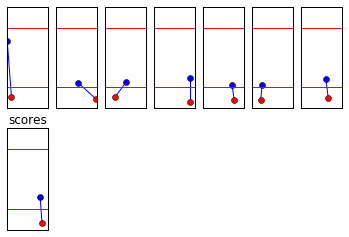

In [34]:
i=1

for assist in df_assists.iterrows():

    plt.subplot(2, 7, i)
    plt.plot([assist[1][2], assist[1][4]], [assist[1][3], assist[1][5]])
    plt.plot([assist[1][2]],[assist[1][3]], 'bo')
    plt.plot([assist[1][4]], [assist[1][5]], 'ro')
    plt.xticks([]);plt.yticks([])
    plt.xlim(0,1);plt.ylim(0,1)

    ## endzones
    normalized_line = 25. / (25+70+25)  ## normalized between 0 and 1, like the X-Y coordinates
    plt.plot([0,1],[normalized_line,normalized_line],'r')
    plt.plot([0,1],[1-normalized_line,1-normalized_line],'r')
    i+=1



In [32]:
renamedict = dict(zip(df_assists.columns,["thrower","receiver","x_T","y_T","x_R","y_R"]))
df_assists = df_assists.rename(columns=renamedict)

In [33]:
df_assists

,thrower,receiver,x_T,y_T,x_R,y_R
16,#22 Paul Simpson,Jamie Chen,0.000000,0.664604,0.104027,0.111386
17,#22 Paul Simpson,Joyce Wang,0.536913,0.250000,0.963087,0.092822
21,#22 Paul Simpson,Joyce Wang,0.510067,0.253713,0.251678,0.113861
27,#69 Justin Chen,#27 Daniel Zhang,0.882550,0.293317,0.882550,0.058168
37,Cecilia Wu,#69 Justin Chen,0.708054,0.231436,0.758389,0.077970
42,Jamie Chen,Melody Zheng,0.244966,0.231436,0.208054,0.084158
46,#27 Daniel Zhang,Jamie Chen,0.604027,0.285891,0.664430,0.100248
61,#69 Justin Chen,Tina Zhu,0.805369,0.327970,0.852349,0.069307


In [6]:
from seaborn import heatmap

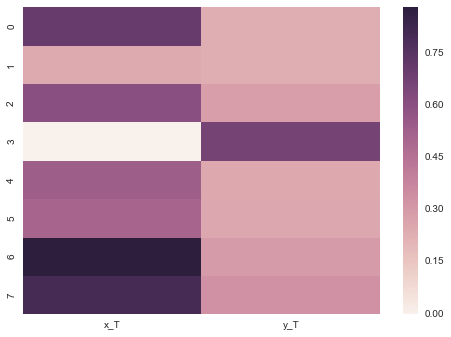

In [7]:
heatmap(data=df_assists.loc[:,["x_T","y_T"]], )

The plot above demonstrates that the heatmap function will take a matrix of values and then plot appropriate colors according to the max-min values of the matrix.  We'll first need to summarize values in a 3x2 grid of the endzone first, and then put that into the heatmap plot.

### Suggestion for how to proceed:

1. create an abstract function labeling the portions of the endzone of interest, taking x-y as input.  We'll vectorize that function over all rows, and create a new column (pd.Series type) for this label.  Call this Series "endzone_partition", and ensure labels are logically named so that sorting is possible, for example "(2,3)" 
2. count all values for the endzone partition -- use pd.Series.value_counts(), indexed by endzone_partition
3. sort values of result from (2) by the index -- use pd.Series.sort_index()
4. reshape the resultant Series by how the endzone is shaped, forming a matrix -- use np.reshape(Series)
5. plot heatmap over this matrix -- use seaborn.heatmap()

In [26]:
## step 1: create a partitioning function, vectorize this over the DataFrame of x-y goal coordinates

def endzone_partition(x,y):
    """ input:  (x,y) coordinate of the location where the goal was caught
        output: endzone partition that (x,y) belongs to 
    """
    # left to right: 0 -> 0.333333; 0.333333 -> 0.666667; 0.666667 -> 1
    # front to back: 0.791667 -> 0.9; 0.9 -> 1
    # front of endzone
    # ----------------------------
    # | (0, 0) | (0, 1) | (0, 2) |
    # ----------------------------
    # | (1, 0) | (1, 1) | (1, 2) |
    # ----------------------------
    # back of endzone
    
    if y < 0.9:
        if x < 0.333333:
            return (0, 0)
        elif x < 0.666667:
            return (0, 1)
        else:
            return (0, 2)
    else:
        if x < 0.333333:
            return (1, 0)
        elif x < 0.666667:
            return (1, 1)
        else:
            return (1, 2)

def endzone_partition_for_lists(x):
    """ wrapper function for endzone_partition, where the input is a length=2 list-type 
        object (including pd.Series, numpy.array).  Necessary for vectorizing the calculations
    """
    
    return endzone_partition(x[0],x[1])


df_assists["endzone_partition"] = df_assists.loc[:,["x_R","y_R"]].apply(endzone_partition_for_lists, axis=1)
print "labeled endzone regions:\n\n",df_assists["endzone_partition"]

labeled endzone regions:

0    (0, 2)
1    (0, 0)
2    (0, 1)
3    (0, 0)
4    (0, 2)
5    (0, 0)
6    (0, 2)
7    (0, 2)
Name: endzone_partition, dtype: object


In [43]:
## 2. count all values for the endzone partition -- use pd.Series.value_counts(), indexed by endzone_partition
scoring_distribution = df_assists["endzone_partition"].value_counts()
print "raw counts:\n\n",df_assists["endzone_partition"].value_counts()

## NOTE: need to force an index onto this function, in case one of the regions is not scored in.
## temporarily, we'll add this by hand.  Long term, we can create an Endzone object, for which we
## can set any number of partitions for, and simplify the process of heatmapping.

s2s,f2b  = 3,2     # for 3 sideline-to-sideline partitions, 2 front-to-back partitions
indx     = [(u,v) for u in range(f2b) for v in range(s2s)]

scoring_distribution = scoring_distribution.reindex(indx,fill_value=0)
print "\nafter forcing an index:\n\n",scoring_distribution

## 3. sort values of result from (2) by the index -- use pd.Series.sort_index()
scoring_distribution = scoring_distribution.sort_index()

raw counts:

(0, 2)    4
(0, 0)    3
(0, 1)    1
Name: endzone_partition, dtype: int64

after forcing an index:

(0, 0)    3
(0, 1)    1
(0, 2)    4
(1, 0)    0
(1, 1)    0
(1, 2)    0
Name: endzone_partition, dtype: int64


[[3 1 4]
 [0 0 0]]


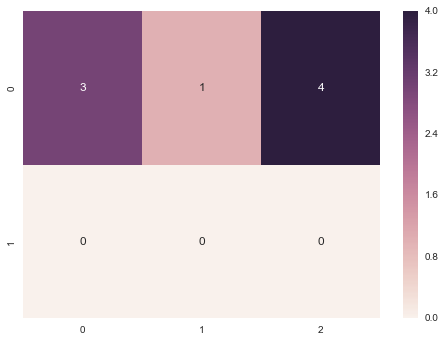

In [40]:
## 4. reshape the resultant Series by how the endzone is shaped, forming a matrix -- use np.reshape(Series)
score_heat = np.reshape(scoring_distribution, (f2b,s2s))
print score_heat

## 5. plot heatmap over this matrix -- use seaborn.heatmap()
heatmap(score_heat,annot=True)

### Example endzone heatmap

In [29]:
example_endzone_heatmap = dirichlet(ones(6))  # Easiest way for me to ensure all partitions of endzone sum to 1...sorry
print example_endzone_heatmap

example_endzone_heatmap = np.reshape(example_endzone_heatmap, (3,2))

print "\nreshaped output:\n", example_endzone_heatmap

[ 0.00773866  0.0769527   0.13160195  0.11050414  0.51652784  0.15667471]

reshaped output:
[[ 0.00773866  0.0769527 ]
 [ 0.13160195  0.11050414]
 [ 0.51652784  0.15667471]]


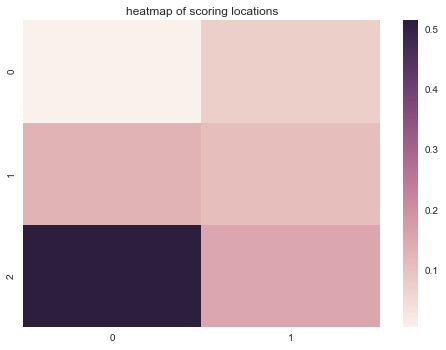

In [31]:
heatmap(example_endzone_heatmap)
title("heatmap of scoring locations")

Feel free to mess with params to make colors better looking or change the shape, number of endzone partitions, etc.